# EDA + Feature Engineering
Load data, explore, and save feature dataset.

In [1]:
import pandas as pd
from pathlib import Path
from typing import Optional

DATA_DIR = Path("Data")

# Expected columns in operations_daily: date, site_id, units_produced, power_kwh, downtime_minutes (optional)
# Expected columns in site_meta: site_id, region, capacity, ...

def read_operations(path: Optional[str] = None, data_dir: Path = DATA_DIR) -> pd.DataFrame:
    REQUIRED_COLS = {"date", "site_id", "units_produced", "power_kwh"}

    def _load(p: Path) -> pd.DataFrame:
        df = pd.read_csv(p, parse_dates=["date"])
        if not REQUIRED_COLS.issubset(df.columns):
            missing = REQUIRED_COLS - set(df.columns)
            raise ValueError(f"{p.name} missing required columns: {missing}")
        return df.sort_values(["site_id", "date"]).reset_index(drop=True)

    if path:
        return _load(Path(path))

    candidates = sorted(data_dir.glob("operations_daily_*.csv"))
    if candidates:
        def _days(p: Path) -> int:
            name = p.stem
            token = name.split("_")[-1]
            return int(token[:-1]) if token.endswith("d") and token[:-1].isdigit() else 0

        chosen = max(candidates, key=_days)
        return _load(chosen)

    fallback = data_dir / "operations_daily.csv"
    if fallback.exists():
        return _load(fallback)

    raise FileNotFoundError("No operations_daily CSV found in Data/")

def read_site_meta(path: Optional[str] = None) -> pd.DataFrame:
    p = Path(path) if path else DATA_DIR / "site_meta.csv"
    if not p.exists():
        raise FileNotFoundError(f"site_meta not found at {p}")
    return pd.read_csv(p)

In [2]:
import pandas as pd
import numpy as np

# Feature engineering utilities
# - Calendar features
# - Rolling means as baselines
# - Site metadata join

def add_calendar_features(df: pd.DataFrame, date_col: str = "date") -> pd.DataFrame:
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col])
    d["dow"] = d[date_col].dt.dayofweek  # 0=Mon
    d["dom"] = d[date_col].dt.day
    d["month"] = d[date_col].dt.month
    d["week"] = d[date_col].dt.isocalendar().week.astype(int)
    d["is_weekend"] = (d["dow"] >= 5).astype(int)
    return d


def add_rolling_features(df: pd.DataFrame,
                         by: list = ["site_id"],
                         date_col: str = "date",
                         targets: list = ["units_produced", "power_kwh"],
                         windows: list = [3, 7, 14, 28]) -> pd.DataFrame:
    d = df.copy()
    d = d.sort_values(by + [date_col])
    for tgt in targets:
        if tgt not in d.columns:
            continue
        for w in windows:
            d[f"{tgt}_rollmean_{w}"] = (
                d.groupby(by)[tgt]
                .transform(lambda s: s.rolling(w, min_periods=max(1, w//2)).mean())
            )
            d[f"{tgt}_rollstd_{w}"] = (
                d.groupby(by)[tgt]
                .transform(lambda s: s.rolling(w, min_periods=max(1, w//2)).std())
            )
    return d


def join_site_meta(ops: pd.DataFrame, site_meta: pd.DataFrame) -> pd.DataFrame:
    meta = site_meta.copy()

    # Normalize join key dtype
    ops["site_id"] = ops["site_id"].astype(str)
    meta["site_id"] = meta["site_id"].astype(str)

    # Encode categoricals except join key
    for c in meta.select_dtypes(include=["object"]).columns:
        if c != "site_id":
            try:
                meta[c] = meta[c].astype("category").cat.codes
            except Exception:
                pass

    return ops.merge(meta, on="site_id", how="left")


def prepare_features(ops: pd.DataFrame, site_meta: pd.DataFrame = None) -> pd.DataFrame:
    d = add_calendar_features(ops)
    d = add_rolling_features(d)
    if site_meta is not None:
        d = join_site_meta(d, site_meta)
    return d

In [3]:
import pandas as pd
from pathlib import Path

ops = read_operations()
meta = read_site_meta()
features = prepare_features(ops, meta)
features.head()

,date,site_id,units_produced,downtime_minutes,power_kwh,rework_units,defects_ppm,staff_count,material_cost_per_unit,price_per_unit,...,power_kwh_rollstd_3,power_kwh_rollmean_7,power_kwh_rollstd_7,power_kwh_rollmean_14,power_kwh_rollstd_14,power_kwh_rollmean_28,power_kwh_rollstd_28,region,commissioned_year,shift_hours_per_day
0,2025-01-01,S1,1280,34,4211,27,453,56,71.94,96.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2018,20
1,2025-01-02,S1,1249,193,5471,40,480,55,71.87,95.90,...,890.954544,NaN,NaN,NaN,NaN,NaN,NaN,2,2018,20
2,2025-01-03,S1,1163,43,4178,33,454,53,72.04,96.11,...,737.172300,4620.0,737.172300,NaN,NaN,NaN,NaN,2,2018,20
3,2025-01-04,S1,1348,32,4554,35,387,54,72.26,95.99,...,665.095732,4603.5,602.802621,NaN,NaN,NaN,NaN,2,2018,20
4,2025-01-05,S1,0,0,0,0,0,0,0.00,0.00,...,2527.712273,3682.8,2123.904588,NaN,NaN,NaN,NaN,2,2018,20


In [4]:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

df = prepare_features(ops, meta)

# --- Summary statistics ---
summary = df.describe()
display(summary.style
        .background_gradient(cmap='coolwarm', axis=1)  # gradient across columns
        .format("{:.2f}")
        .set_caption("--- Summary Statistics ---"))

# --- Missing values ---
missing = df.isna().sum().to_frame(name="Missing Count")
display(missing.style
        .background_gradient(cmap='Reds', axis=0)  # gradient down the rows
        .set_caption("--- Missing Values per Column ---"))

,date,units_produced,downtime_minutes,power_kwh,rework_units,defects_ppm,staff_count,material_cost_per_unit,price_per_unit,temperature_c,rainfall_mm,holiday_flag,dow,dom,month,week,is_weekend,units_produced_rollmean_3,units_produced_rollstd_3,units_produced_rollmean_7,units_produced_rollstd_7,units_produced_rollmean_14,units_produced_rollstd_14,units_produced_rollmean_28,units_produced_rollstd_28,power_kwh_rollmean_3,power_kwh_rollstd_3,power_kwh_rollmean_7,power_kwh_rollstd_7,power_kwh_rollmean_14,power_kwh_rollstd_14,power_kwh_rollmean_28,power_kwh_rollstd_28,region,commissioned_year,shift_hours_per_day
count,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1456.00,1452.00,1452.00,1436.00,1436.00,1408.00,1408.00,1460.00,1456.00,1452.00,1452.00,1436.00,1436.00,1408.00,1408.00,1460.00,1460.00,1460.00
mean,.2f,1207.76,61.69,4274.85,27.00,423.37,51.55,66.70,89.98,27.93,0.54,0.07,3.00,15.72,6.53,26.43,0.28,1207.77,237.20,1206.85,288.01,1205.22,317.76,1203.55,334.50,4274.34,939.61,4271.24,1116.78,4266.17,1208.54,4263.36,1258.55,1.50,2017.25,20.00
min,.2f,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.80,0.00,0.00,0.00,1.00,1.00,1.00,0.00,335.00,2.00,615.86,15.57,819.43,74.49,914.82,92.97,1230.00,3.54,2294.71,148.20,3046.43,293.13,3331.18,383.86,0.00,2015.00,16.00
25%,.2f,1116.00,42.00,3961.50,22.00,375.00,50.00,70.18,94.84,23.90,0.00,0.00,1.00,8.00,4.00,13.00,0.00,1062.33,77.84,1076.71,124.95,1078.38,150.20,1081.26,273.22,3836.92,319.14,3880.32,508.04,3887.45,707.62,3919.70,1063.48,0.75,2015.75,19.00
50%,.2f,1276.00,56.00,4456.00,28.00,446.00,55.00,71.48,95.40,27.80,0.00,0.00,3.00,16.00,7.00,26.00,0.00,1240.00,129.33,1217.14,165.94,1215.21,352.08,1210.77,352.11,4397.67,568.06,4265.86,877.67,4247.18,1290.49,4281.16,1321.53,1.50,2017.00,20.00
75%,.2f,1422.00,69.00,4955.00,34.00,509.00,58.00,72.30,97.83,32.00,0.00,0.00,5.00,23.00,10.00,39.00,1.00,1387.00,223.48,1336.29,498.03,1332.73,422.44,1315.61,421.19,4843.08,1167.75,4743.71,1770.04,4683.04,1577.12,4627.21,1527.39,2.25,2018.50,21.00
max,.2f,1882.00,333.00,7970.00,52.00,774.00,67.00,73.52,99.81,36.40,12.70,1.00,6.00,31.00,12.00,52.00,1.00,1725.67,991.26,1596.86,808.85,1530.14,667.45,1494.61,554.56,6307.67,3814.75,5724.43,2766.16,5339.43,2446.97,5223.21,2051.80,3.00,2020.00,24.00
std,nan,372.81,47.36,1348.80,10.26,142.94,14.51,17.74,23.94,4.42,1.68,0.25,2.00,8.80,3.45,15.05,0.45,239.63,257.68,183.19,202.51,159.81,152.07,147.56,111.96,832.83,898.52,600.54,681.80,493.39,509.75,440.24,375.47,1.12,1.92,2.83


,Missing Count
date,0
site_id,0
units_produced,0
downtime_minutes,0
power_kwh,0
rework_units,0
defects_ppm,0
staff_count,0
material_cost_per_unit,0
price_per_unit,0


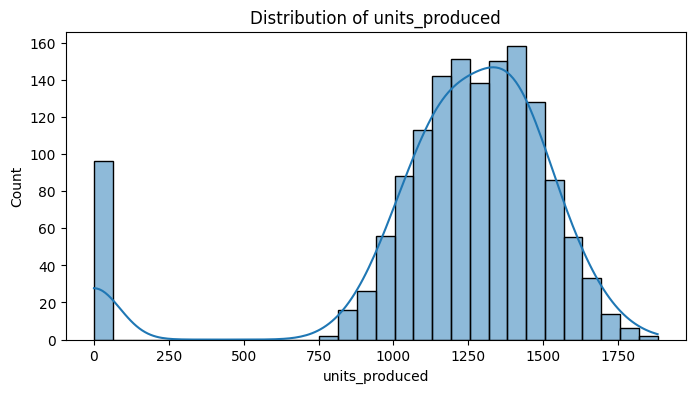

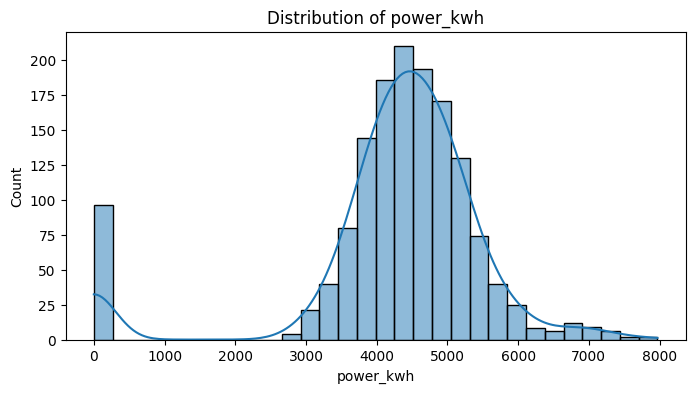

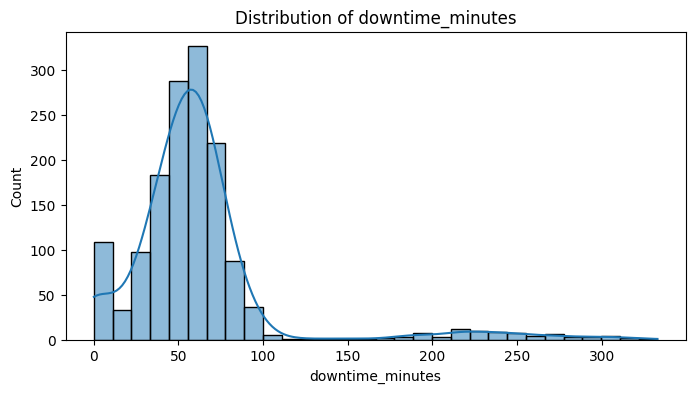

In [5]:
# --- Distribution of key metrics ---
metrics = ["units_produced", "power_kwh", "downtime_minutes"]  # downtime might be optional

for col in metrics:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Distribution of {col}")
        plt.show()

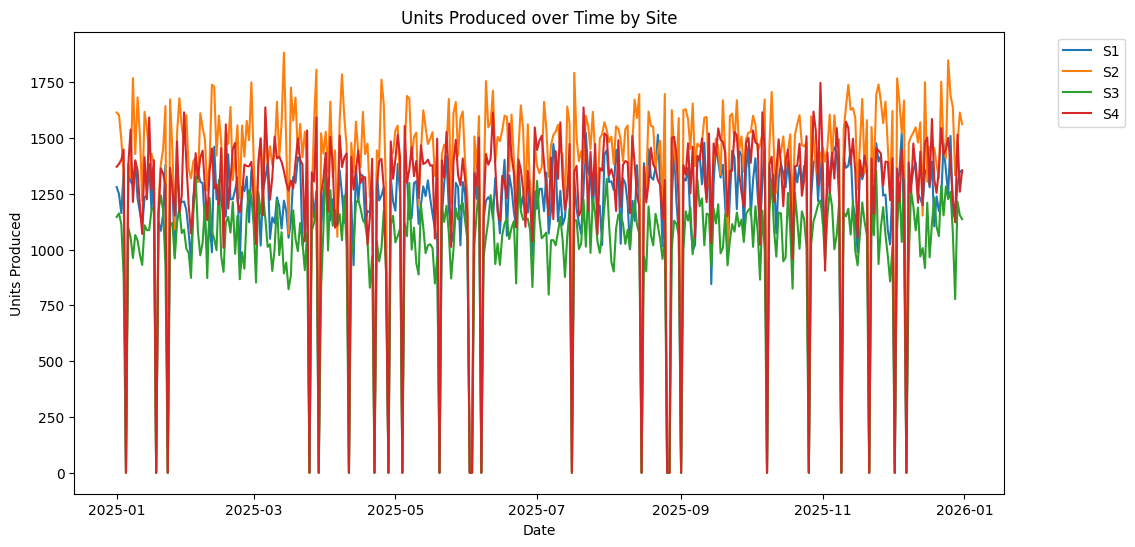

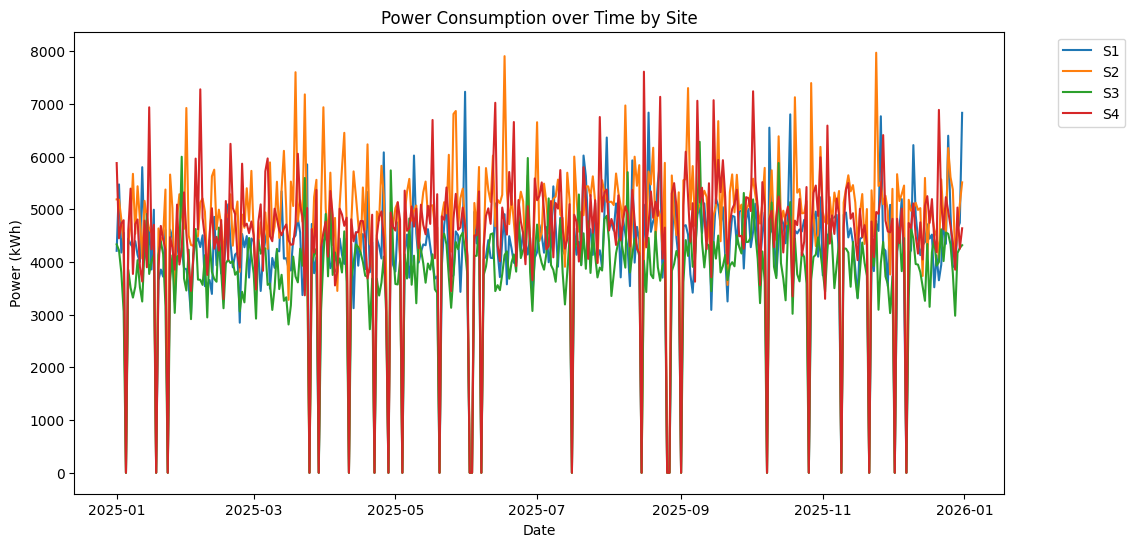

In [6]:
# --- Time Series Trends ---
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="date", y="units_produced", hue="site_id")
plt.title("Units Produced over Time by Site")
plt.xlabel("Date")
plt.ylabel("Units Produced")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="date", y="power_kwh", hue="site_id")
plt.title("Power Consumption over Time by Site")
plt.xlabel("Date")
plt.ylabel("Power (kWh)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

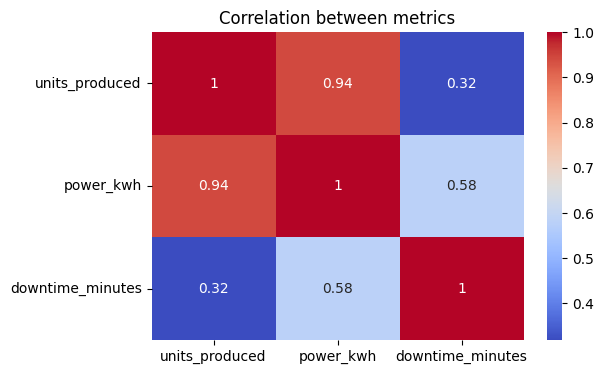

In [7]:
# --- Correlation Analysis ---
corr_cols = ["units_produced", "power_kwh"]
if "downtime_minutes" in df.columns:
    corr_cols.append("downtime_minutes")

plt.figure(figsize=(6,4))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between metrics")
plt.show()

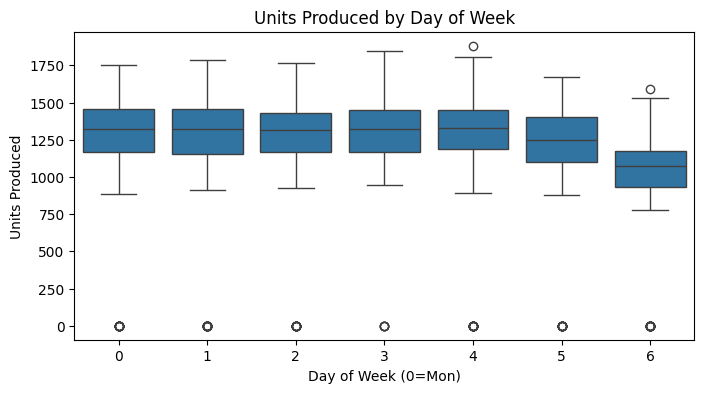

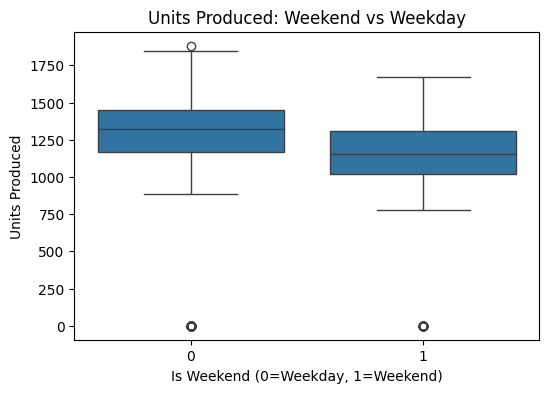

In [8]:
# --- Calendar Feature Analysis ---
# Units produced by day of week
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="dow", y="units_produced")
plt.title("Units Produced by Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Units Produced")
plt.show()

# Weekend vs Weekday comparison
if "is_weekend" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="is_weekend", y="units_produced")
    plt.title("Units Produced: Weekend vs Weekday")
    plt.xlabel("Is Weekend (0=Weekday, 1=Weekend)")
    plt.ylabel("Units Produced")
    plt.show()